In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings 

# Business Problem

In today's interconnected, globalized economy with supply chains and shipping routes spanning across the globe, the ability to accurately deliver an order at the promised time is paramount to customer satisfaction. Ability to predict delays and take appropriate corrective actions would be beneficial to brand image, customer satisfaction and in turn, higher customer retentions and more orders, which would increase sales and profits!

# The Dataset

### Fields in the dataset

| FIELDS | DESCRIPTION |
|---|---|
| Type | Type of transaction made |
| Days for shipping (real) | Actual shipping days of the purchased product |
| Days for shipment (scheduled) | Days of scheduled delivery of the purchased product |
| Benefit per order | Earnings per order placed |
| Sales per customer | Total sales per customer made per customer |
| Delivery Status | Delivery status of orders: Advance shipping, Late delivery, Shipping canceled, Shipping on time |
| Late_delivery_risk | Categorical variable that indicates if sending is late (1), it is not late (0) |
| Category Id | Product category code |
| Category Name | Description of the product category |
| Customer City | City where the customer made the purchase |
| Customer Country | Country where the customer made the purchase |
| Customer Email | Customer's email |
| Customer Fname | Customer name | 
| Customer Id | Customer ID |
| Customer Lname | Customer lastname |
| Customer Password | Masked customer key |
| Customer Segment | Types of Customers: Consumer, Corporate, Home Office |
| Customer State | State to which the store where the purchase is registered belongs |
| Customer Street | Street to which the store where the purchase is registered belongs |
| Customer Zipcode | Customer Zipcode |
| Department Id | Department code of store |
| Department Name | Department name of store |
| Latitude | Latitude corresponding to location of store |
| Longitude | Longitude corresponding to location of store |
| Market | Market to where the order is delivered: Africa, Europe, LATAM, Pacific Asia, USCA |
| Order City | Destination city of the order |
| Order Country | Destination country of the order |
| Order Customer Id | Customer order code |
| order date (DateOrders) | Date on which the order is made |
| Order Id | Order code |
| Order Item Cardprod Id | Product code generated through the RFID reader |
| Order Item Discount | Order item discount value |
| Order Item Discount Rate | Order item discount percentage |
| Order Item Id | Order item code |
| Order Item Product Price | Price of products without discount |
| Order Item Profit Ratio | Order Item Profit Ratio |
| Order Item Quantity | Number of products per order |
| Sales | Value in sales |
| Order Item Total | Total amount per order |
| Order Profit Per Order | Order Profit Per Order |
| Order Region | Region of the world where the order is delivered: Southeast Asia, South Asia, Oceania, Eastern Asia, West Asia, West of USA, US Center, West Africa, Central Africa, North Africa, Western Europe, Northern, Caribbean, South America, East Africa, Southern Europe, East of USA, Canada, Southern Africa, Central Asia, Europe, Central America, Eastern Europe, South of USA |
| Order State | State of the region where the order is delivered |
| Order Status | Order Status: COMPLETE, PENDING, CLOSED, PENDING_PAYMENT, CANCELED, PROCESSING, SUSPECTED_FRAUD, ON_HOLD, PAYMENT_REVIEW |
| Product Card Id | Product code |
| Product Category Id | Product category code |
| Product Description | Product Description |
| Product Image | Link of visit and purchase of the product |
| Product Name | Product Name |
| Product Price | Product Price |
| Product Status | Status of the product stock: If it is 1 not available, 0 the product is available |
| Shipping date (DateOrders) | Exact date and time of shipment |
| Shipping Mode | The following shipping modes are presented: Standard Class, First Class, Second Class, Same Day |

### We will be exploring how 'Days of Shipping(real)' and 'Days of Shipping(Scheduled)' are related and create a model to predict if the gap between the two would be zero or not? if zero, its on-time delivery.

This could be approached in two  ways - 
1. Treat Days of shipping(real) as a real value and apply regression techniques to predict the scheduled Days of shipping value to be as close to the real one as possible
2. Consider the difference between the the Real and Scheduled Days of shipping and treat this a a bianry problem and predict Yes/No for met/not-not met sceanrios and approach this as a Classification problem
   
For the purposes of this analysis, we will take the second path and model this as a yes/no question that would provide insights to the operations /logistcs team if there is a lurking danger of missing OTD on a particualr order (Even before the shipping process has started) and enable them to take corrective actions. We will only consider Late deliveries as 'missed' and treat early deliveries as 'me'. 
et'.

In [2]:
#Load Data
data_df = pd.read_csv(r'C:\data\capstone\data\DataCoSupplyChainDataset.csv', encoding='latin-1')

In [3]:
data_df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [4]:
data_df.shape

(180519, 53)

### Target Details

In [115]:
#Find how many met and not-met records we have. We will treat records that got delivered ahead of time also as 'not-met' for this analysis. 
#Early delivery could create issues at receiver side if they are not ready to process the orders on the said date

data_df['gap'] = data_df['Days for shipment (scheduled)'] - data_df['Days for shipping (real)'] 
#otd = 1 means met and otd = 0 means not-met
data_df['otd'] = data_df.apply(lambda row: 1 if row['Days for shipping (real)'] <= row['Days for shipment (scheduled)'] else 0, axis = 1 )
data_df['otd'].value_counts(normalize=True)

otd
0    0.572793
1    0.427207
Name: proportion, dtype: float64

In [6]:
data_df['gap'].value_counts().sort_index()

gap
-4     6983
-3     7052
-2    28718
-1    60647
 0    33753
 1    21700
 2    21666
Name: count, dtype: int64

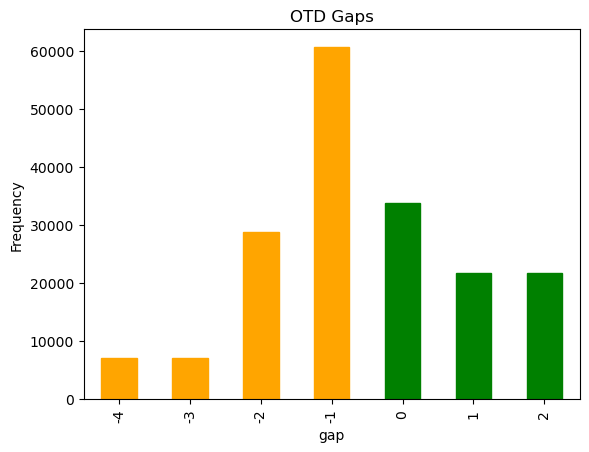

In [118]:
#visualizing this
ax = data_df['gap'].value_counts().sort_index().plot(kind='bar', title='OTD Gaps', ylabel='Frequency')
bars = ax.patches
for bar, value in zip(bars, data_df['gap'].value_counts().sort_index().index):
    if value < 0 :
        bar.set_color( 'orange' )
    else:
        bar.set_color('green')
plt.savefig(r'C:\data\capstone\analysis\target_analysis.png')
plt.show()

Based on this, there is an approxiamte 60/40 split between 'not-met' and 'met' scenarios. We would need to keep this in mind as we start modeling the data. Further, we would be treating any order that was not delivered on the promised date as OTD not met.

### Features 

In [8]:
X = data_df

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 55 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [10]:
X.describe()

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,...,Order Item Total,Order Profit Per Order,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Price,Product Status,gap,otd
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180516.000000,180519.000000,180519.000000,...,180519.000000,180519.000000,24840.000000,180519.000000,180519.000000,0.0,180519.000000,180519.0,180519.000000,180519.000000
mean,3.497654,2.931847,21.974989,183.107609,0.548291,31.851451,6691.379495,35921.126914,5.443460,29.719955,...,183.107609,21.974989,55426.132327,692.509764,31.851451,NaN,141.232550,0.0,-0.565807,0.427207
std,1.623722,1.374449,104.433526,120.043670,0.497664,15.640064,4162.918106,37542.461122,1.629246,9.813646,...,120.043670,104.433526,31919.279101,336.446807,15.640064,NaN,139.732492,0.0,1.490966,0.494674
min,0.000000,0.000000,-4274.979980,7.490000,0.000000,2.000000,1.000000,603.000000,2.000000,-33.937553,...,7.490000,-4274.979980,1040.000000,19.000000,2.000000,NaN,9.990000,0.0,-4.000000,0.000000
25%,2.000000,2.000000,7.000000,104.379997,0.000000,18.000000,3258.500000,725.000000,4.000000,18.265432,...,104.379997,7.000000,23464.000000,403.000000,18.000000,NaN,50.000000,0.0,-1.000000,0.000000
50%,3.000000,4.000000,31.520000,163.990005,1.000000,29.000000,6457.000000,19380.000000,5.000000,33.144863,...,163.990005,31.520000,59405.000000,627.000000,29.000000,NaN,59.990002,0.0,-1.000000,0.000000
75%,5.000000,4.000000,64.800003,247.399994,1.000000,45.000000,9779.000000,78207.000000,7.000000,39.279617,...,247.399994,64.800003,90008.000000,1004.000000,45.000000,NaN,199.990005,0.0,0.000000,1.000000
max,6.000000,4.000000,911.799988,1939.989990,1.000000,76.000000,20757.000000,99205.000000,12.000000,48.781933,...,1939.989990,911.799988,99301.000000,1363.000000,76.000000,NaN,1999.989990,0.0,2.000000,1.000000


Some of these columns are either keys or, highly correlated with each other, which will not help in identifying issues and hence should be removed
- Order Id, Order Customer Id, Order Item Id : Key
- Category Name : Co-rrelated to Category Id
- Customer Email, Customer Fname, Customer Lname, Customer Password : Co-rrelated to Customer Id 
- Department Name : Co-rrelated to Department Id
- Product Image, Product Name, Product Description: Co-rrelated to  Product Card Id


Other items to ponder
- Group order date and shipping date into week, day of week and month buckets
- Also consider to add the gap between order date and shipping date


In [11]:
X_rationalized = X.drop(['Order Id', 'Order Customer Id', 'Order Item Id', 'Category Name', 'Customer Email', 'Customer Fname', 'Customer Lname', 'Customer Password', 'Department Name', 'Product Description','Product Image', 'Product Name'], axis = 1)

In [12]:
#understand content of X_rationalized
data_zip = zip(X_rationalized.columns, X_rationalized.dtypes, X_rationalized.isnull().sum(), X_rationalized.nunique(), np.round((X_rationalized.isnull().sum()/X_rationalized.shape[0])*100,2))
data_col = pd.DataFrame(data_zip, columns=['Column Name', 'Type', 'Null Count', 'Unique Count', 'Null %'])
data_col.set_index('Column Name', inplace = True)
data_col

,Type,Null Count,Unique Count,Null %
Column Name,,,,
Type,object,0,4,0.00
Days for shipping (real),int64,0,7,0.00
Days for shipment (scheduled),int64,0,4,0.00
Benefit per order,float64,0,21998,0.00
Sales per customer,float64,0,2927,0.00
Delivery Status,object,0,4,0.00
Late_delivery_risk,int64,0,2,0.00
Category Id,int64,0,51,0.00
Customer City,object,0,563,0.00


Order Zip code has a large amount of null. This column can be removed. There are three records with Customer zip as Null. Lets remove those rows as well

In [13]:
X_rationalized.drop('Order Zipcode', axis = 1, inplace=True)
X_rationalized.dropna(subset = ['Customer Zipcode'], inplace = True)

Convert Dates to Epochs as well as specific components

In [14]:
#shipping date (DateOrders), order date (DateOrders). We will split this to epoch, day of week, week of year, month and year 
for col in ['shipping date (DateOrders)', 'order date (DateOrders)' ]:
    X_rationalized[col] = pd.to_datetime(X_rationalized[col])
    X_rationalized[f'{col.split()[0]}_epoch'] = X_rationalized[col].apply(lambda x: x.timestamp())
    X_rationalized[f'{col.split()[0]}_dayofweek'] = X_rationalized[col].dt.dayofweek
    X_rationalized[f'{col.split()[0]}_weekofyear'] = X_rationalized[col].dt.isocalendar().week.astype(int) 
    X_rationalized[f'{col.split()[0]}_month'] = X_rationalized[col].dt.month
    X_rationalized[f'{col.split()[0]}_year'] = X_rationalized[col].dt.year
    X_rationalized[f'{col.split()[0]}_dayofmonth'] = X_rationalized[col].dt.day 
X_rationalized.drop(['shipping date (DateOrders)', 'order date (DateOrders)'], axis = 1, inplace=True)

In [15]:
#understand content of X_rationalized
data_zip = zip(X_rationalized.columns, X_rationalized.dtypes, X_rationalized.isnull().sum(), X_rationalized.nunique(), np.round((X_rationalized.isnull().sum()/X_rationalized.shape[0])*100,2))
data_col = pd.DataFrame(data_zip, columns=['Column Name', 'Type', 'Null Count', 'Unique Count', 'Null %'])
data_col.set_index('Column Name', inplace = True)
data_col

,Type,Null Count,Unique Count,Null %
Column Name,,,,
Type,object,0,4,0.0
Days for shipping (real),int64,0,7,0.0
Days for shipment (scheduled),int64,0,4,0.0
Benefit per order,float64,0,21998,0.0
Sales per customer,float64,0,2927,0.0
Delivery Status,object,0,4,0.0
Late_delivery_risk,int64,0,2,0.0
Category Id,int64,0,51,0.0
Customer City,object,0,562,0.0


In [16]:
df = X_rationalized.drop(['order_epoch','shipping_epoch', 'Days for shipping (real)', 'otd'], axis = 1)

In [17]:
import math
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols.size, categorical_cols.size

(34, 14)

#### Categorical Features spread

'Other' category in Type represents 0.00% of the data
'Other' category in Delivery Status represents 0.00% of the data
'Other' category in Customer City represents 52.12% of the data
'Other' category in Customer Country represents 0.00% of the data
'Other' category in Customer Segment represents 0.00% of the data
'Other' category in Customer State represents 18.55% of the data
'Other' category in Customer Street represents 99.39% of the data
'Other' category in Market represents 0.00% of the data
'Other' category in Order City represents 90.93% of the data
'Other' category in Order Country represents 44.54% of the data
'Other' category in Order Region represents 26.14% of the data
'Other' category in Order State represents 80.63% of the data
'Other' category in Order Status represents 0.00% of the data
'Other' category in Shipping Mode represents 0.00% of the data


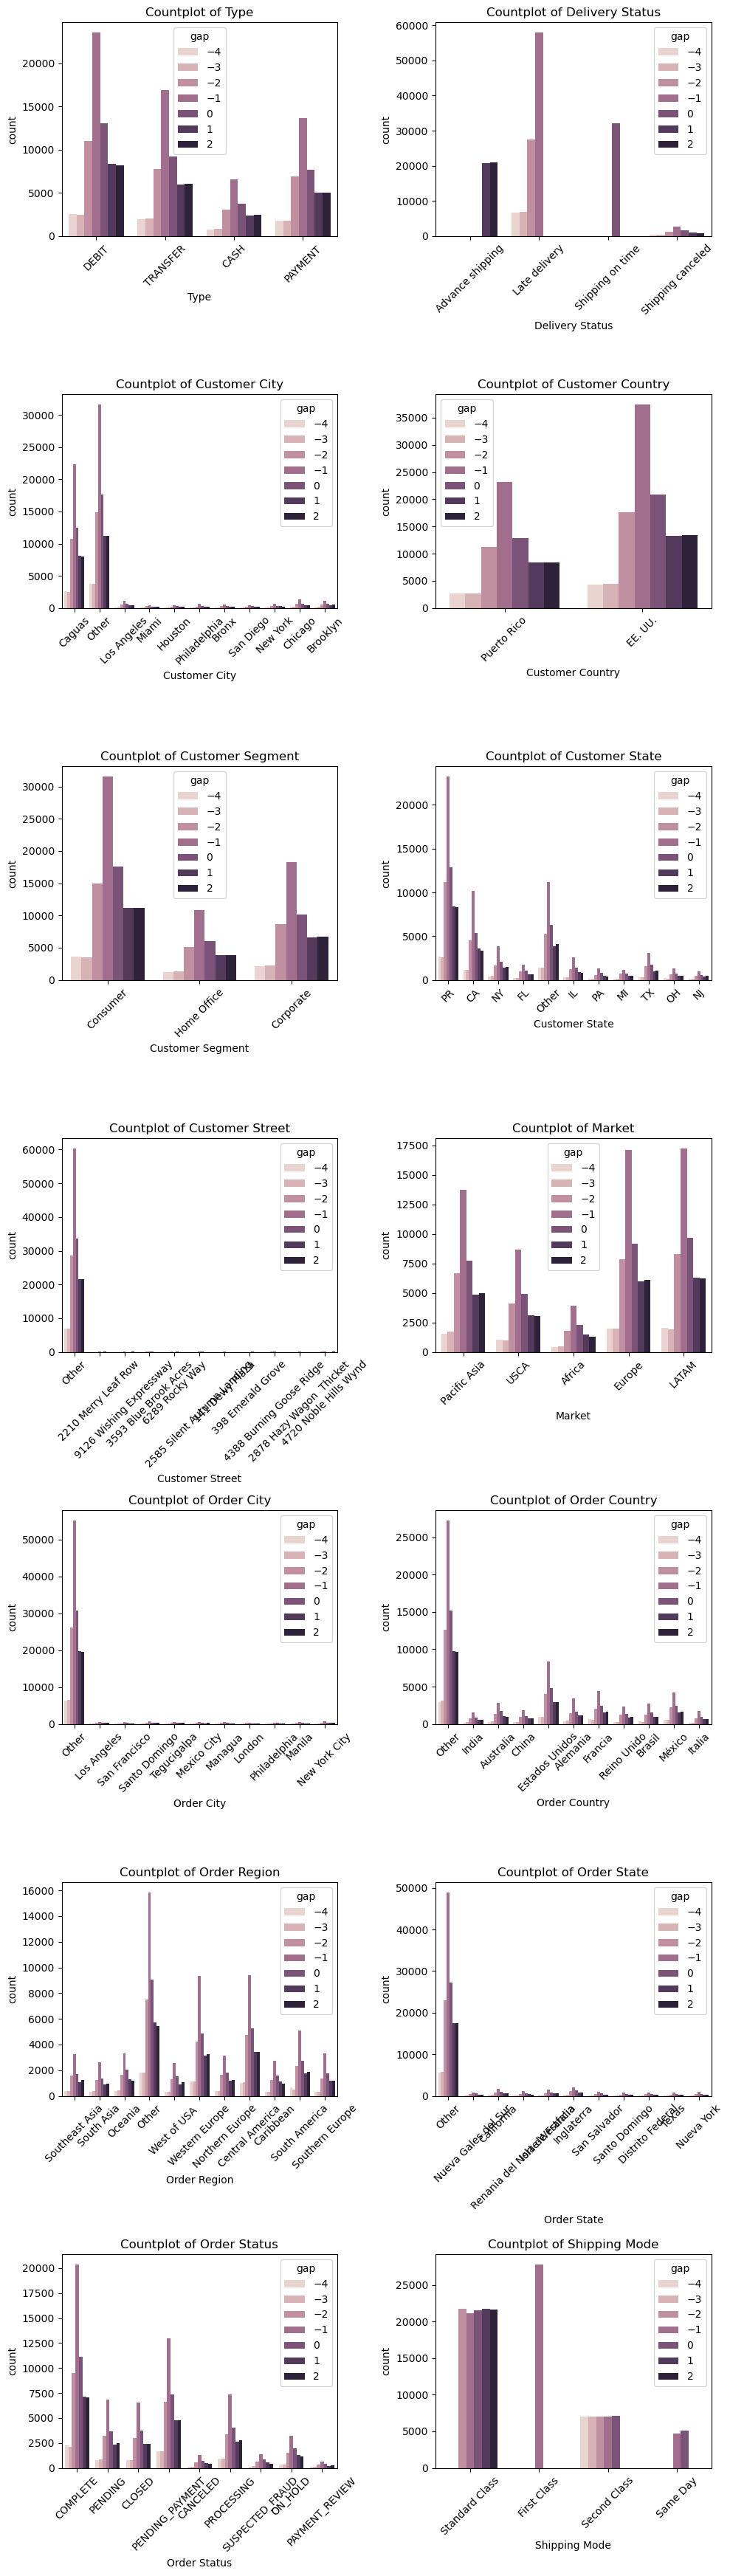

In [18]:
# Bar charts for categorical features
n_cols = 2  # Number of columns in the subplot grid
n_rows = math.ceil(len(categorical_cols) / n_cols)

# Create subplots for categorical features
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))

# Loop through the categorical columns
for i, col in enumerate(categorical_cols):

    row = i // n_cols
    col_index = i % n_cols

    # Calculate value counts
    value_counts = df[col].value_counts()

    top_n = 10  # Display the top 10 categories

    # Get the top N categories and 'Other'
    top_n_labels = value_counts[:top_n].index.tolist()
    other_label = 'Other'

    # Create a new column with combined categories
    df['combined_' + col] = np.where(df[col].isin(top_n_labels), df[col], other_label)

    # Use the 'hue' parameter with the combined column
    sns.countplot(data=df, x='combined_' + col, hue='gap', ax=axes[row, col_index])

    axes[row, col_index].set_title(f'Countplot of {col}')
    axes[row, col_index].set_xlabel(col)
    axes[row, col_index].tick_params(axis='x', rotation=45)

    # Calculate the percentage of 'Other'
    other_percentage = (len(df[df['combined_' + col] == other_label]) / len(df)) * 100
    print(f"'Other' category in {col} represents {other_percentage:.2f}% of the data")
   

plt.tight_layout()

# Save image
plt.savefig(r'C:\data\capstone\analysis\categorical_analysis_count_plots.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Delivery Status tracks the shipping status, and hence, OTD directly. This field should be removed. Further, the cancelled shipments should not be considered for this analysis. They would be removed as well.

As 'Other' category in Customer Street represents 99.39% of the data, we will remove field as categorizing this would result in computational inefficiencies as well as overfitting

#### Numerical Features Spread

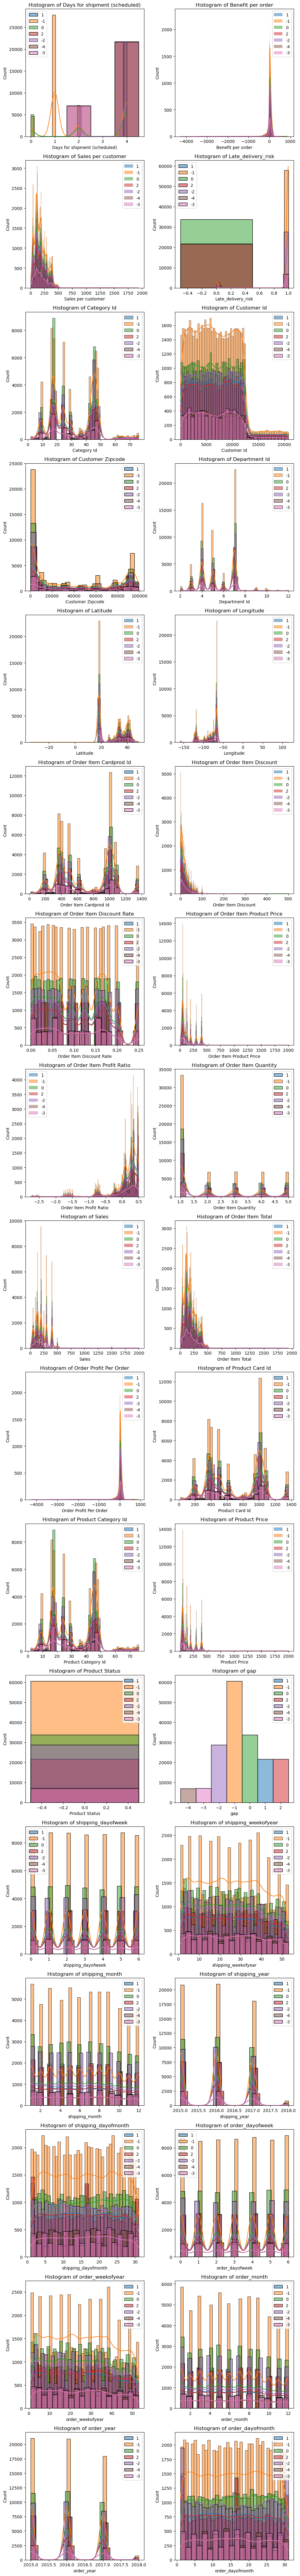

In [19]:
# Histogram for numerical features

# Calculate the number of rows and columns for the subplots
n_cols = 2  
n_rows = math.ceil(len(numerical_cols) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows)) 

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through the numerical columns and create histograms in the subplots
# sns.set_palette('Set1')
for i, col in enumerate(numerical_cols):
    for target_val in df['gap'].unique():
        sns.histplot(df[df['gap'] == target_val][col], kde=True, ax=axes[i], label=target_val, alpha = 0.5)
    
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].legend()  # Add a legend to the subplot

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save image
plt.savefig(r'C:\data\capstone\analysis\numerical_analysis_histograms.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Do not see any obvious direct relationships between the various numberical fields and the target, but, product status field is alwas 0. That can be removed

In [20]:
df.drop(['Customer Street', 'Delivery Status', 'Product Status'], axis = 1, inplace = True, errors='ignore')
categorical_cols = categorical_cols.difference(['Customer Street','Delivery Status'])
numerical_cols = numerical_cols.difference(['Product Status'])

In [21]:
# As we have a large dataset, going to sample it for the purposes of data processing. 
# Will ensure the weight of the gap column in maintained in this split as well
prob = df['gap'].value_counts(normalize=True)
weights = 1 / prob
weights_alingned = df['gap'].map(weights)
df_small = df.sample(frac=0.2, weights=weights_alingned, random_state=42)

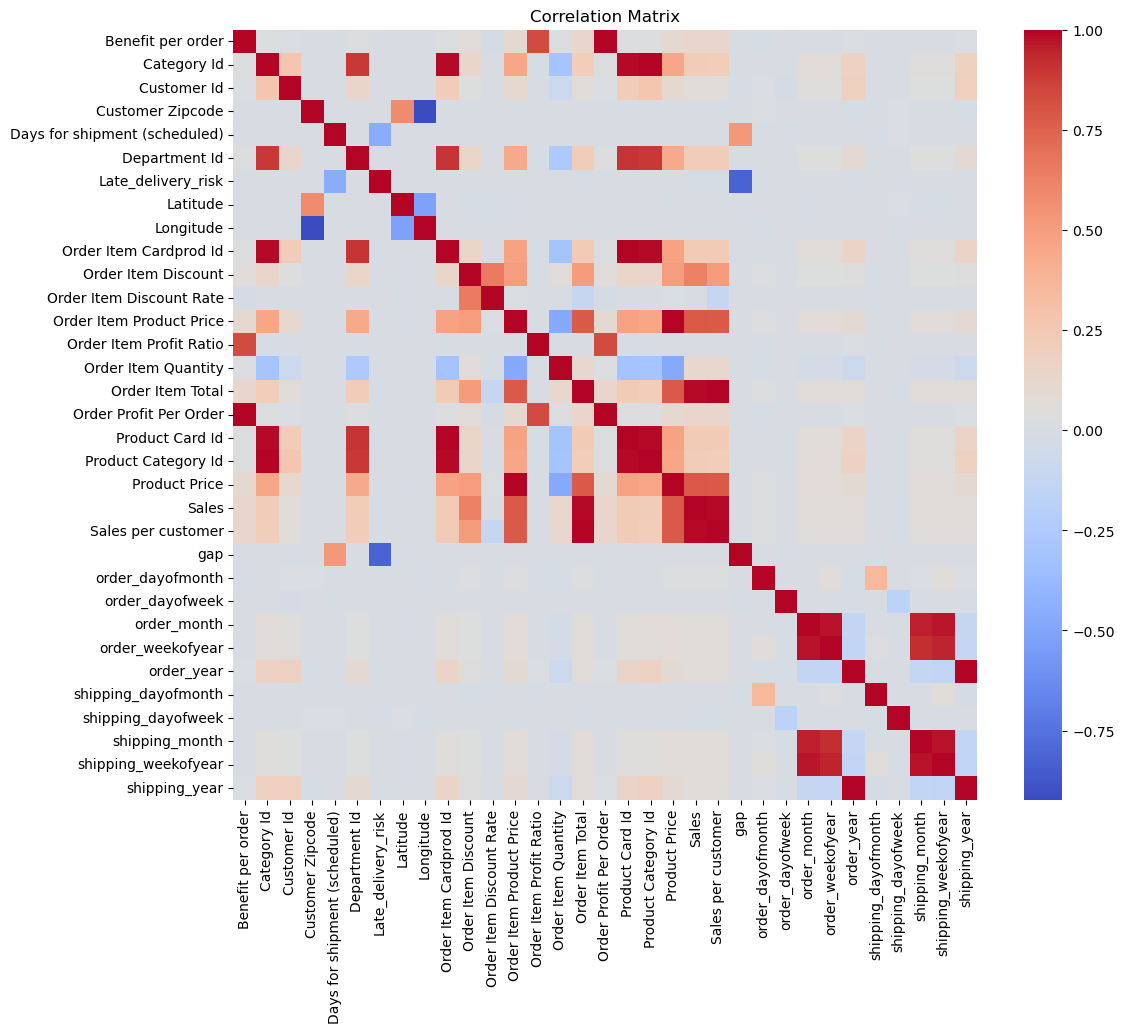

In [22]:
# Correlation matrix heatmap
corr_matrix = df_small[numerical_cols].corr()
plt.figure(figsize=(12, 10)) 
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig(r'C:\data\capstone\analysis\corr_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

 - Order Dates and Shipping dates have very high correlation. Further, the month and weeks have high correlation as well. Hence, dropping those. Further, Order with 'Shipping Cancelled' status should be removed
 - 'Category Id', 'Department Id', 'Product Category Id', 'Product Card Id' and 'Order Item Cardprod Id' have high positive correlation. To reduce computation, will only keep the 'Department Id' and drop the others
 - 'Order Item Total' has very high correlation with 'Product Price' and 'Sales per customer'. Only 'Product Price Benefit per order' will be kept
 - 'Order Profit Per Order' and 'Order Item Profit Ratio' are highly correlated. Will keep only the latter
 - 'Order Item Product Price' and 'Product Price' are highly correlated. Keeping only the latter here as well
 - 'Order Item Quantity' and 'Product price' have a very high inverse relationship. Will keep 'Order Item Quantity'
 - 'Order Item Discount' and 'Order Item Discount Rate' have high correlation. Only keeping the latter
 - 'Late Delivery Risk' and 'Gap' have high correlation, and it looks like it is captured based on actual shipping data. Hence, removing it
 - 'Customer Zip Code' and 'longitude/latitude' have a very high correlation. Removing the former former


In [23]:
data_final = X_rationalized[X_rationalized['Delivery Status'] != 'Shipping canceled']

data_final = data_final.drop(['Customer Street', 'Product Status',  'Delivery Status',
                                  'shipping_weekofyear', 'shipping_month','shipping_year', 'order_weekofyear',
                                  'Product Card Id', 'Order Item Cardprod Id', 'Product Category Id', 'Category Id',
                                  'Order Item Total', 'Sales per customer',
                                  'Order Profit Per Order', 'Order Item Profit Ratio',
                                  'Late_delivery_risk',
                                  'Product Price',
                                  'Order Item Product Price', 'Order Item Discount',
                                  'Customer Zipcode',
                                  'order_epoch', 'shipping_epoch'], axis = 1)

numerical_cols_final = data_final.select_dtypes(include=['number']).columns
categorical_cols_final = data_final.select_dtypes(include=['object']).columns

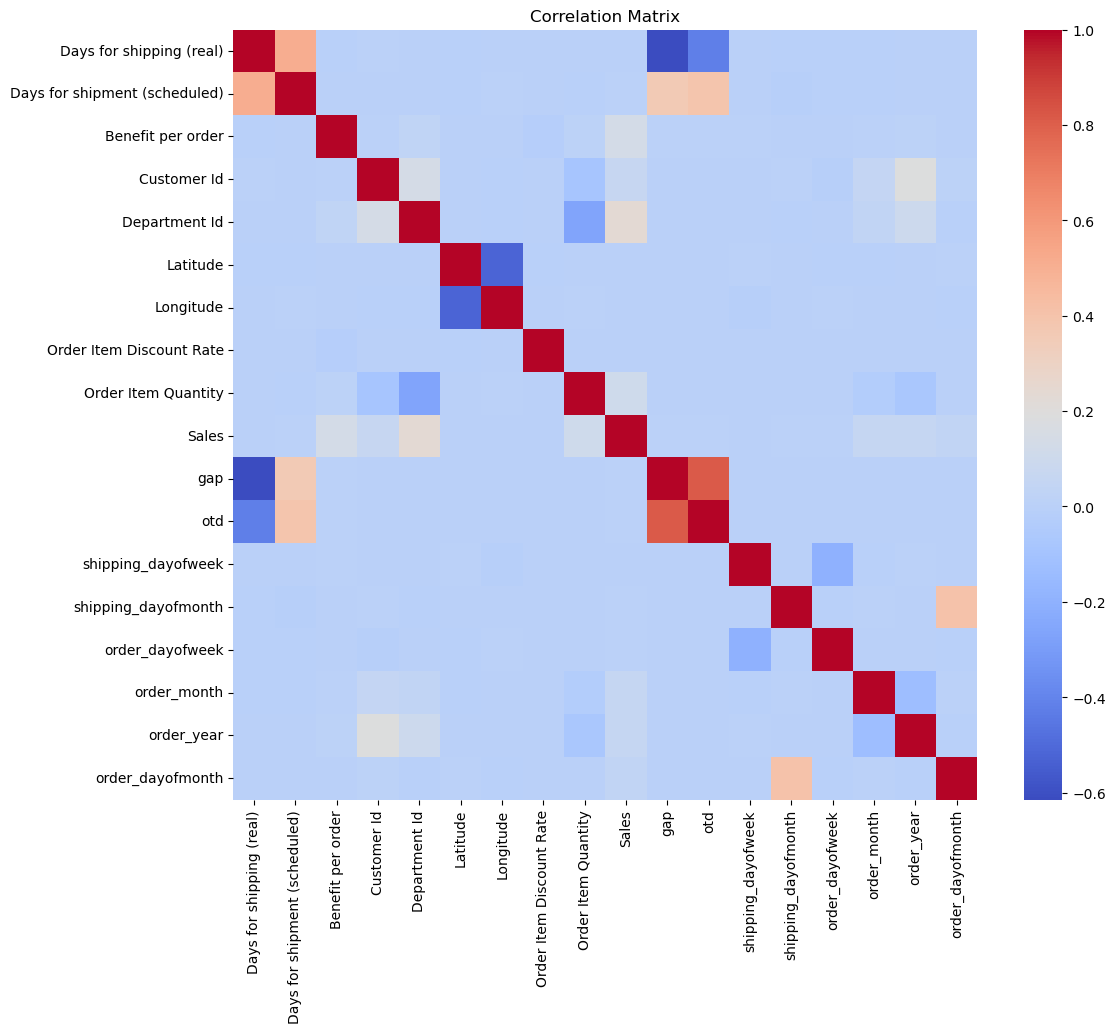

In [24]:
# Correlation matrix heatmap
corr_matrix_final = data_final[numerical_cols_final].corr()
plt.figure(figsize=(12, 10)) 
sns.heatmap(corr_matrix_final, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig(r'C:\data\capstone\analysis\corr_matrix_final.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
# Scatter plots for numerical feature pairs
# sns.pairplot(data_final, vars=data_final.select_dtypes(include=['number']).columns, hue='gap', palette='pastel' )
# plt.savefig(r'C:\data\capstone\analysis\pair_plot.png', dpi=300, bbox_inches='tight')
# plt.show()

In [26]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172762 entries, 0 to 180518
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           172762 non-null  object 
 1   Days for shipping (real)       172762 non-null  int64  
 2   Days for shipment (scheduled)  172762 non-null  int64  
 3   Benefit per order              172762 non-null  float64
 4   Customer City                  172762 non-null  object 
 5   Customer Country               172762 non-null  object 
 6   Customer Id                    172762 non-null  int64  
 7   Customer Segment               172762 non-null  object 
 8   Customer State                 172762 non-null  object 
 9   Department Id                  172762 non-null  int64  
 10  Latitude                       172762 non-null  float64
 11  Longitude                      172762 non-null  float64
 12  Market                         1727

In [27]:
data_final[['Benefit per order', 'Latitude', 'Longitude', 'Sales']] = data_final[['Benefit per order', 'Latitude', 'Longitude', 'Sales']].astype(int)

## Modeling

First, Let us approach this as a classification problem - Can the system predict if this order would be delivered on time or not?

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 

In [29]:
# For this, target is the otd column. So, let us create X and y accordingly
data_class = data_final.drop(['gap', 'Days for shipping (real)'], axis = 1)

As the dataset is large, running the tests on full datasets is computationally expensive. Hence, using a randomly sampled, 50% mix with the same met/not-met split

In [30]:
prob2 = data_class['otd'].value_counts(normalize=True)
weights2 = 1 / prob
weights_alingned2 = data_class['otd'].map(weights)
df_final_small = data_class.sample(frac=0.5, weights=weights_alingned, random_state=42)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_final_small.drop(['otd'], axis =1),df_final_small['otd'], shuffle=True, test_size = 0.2 ,stratify=df_final_small['otd'])

In [32]:
# X_train_for_smote, X_test, y_train_for_smote, y_test = train_test_split(df_final_small.drop(['otd'], axis =1),df_final_small['otd'], shuffle=True, test_size = 0.2 ,stratify=df_final_small['otd'])
# X_train, X_hidden, y_train, y_hidden = train_test_split(X_train_for_smote,y_train_for_smote, shuffle=True, test_size = 0.2 ,stratify=y_train_for_smote)

In [33]:
# cat_index = [X_train.columns.get_loc(col) for col in X_train.select_dtypes(include=['object', 'category']).columns]

In [34]:
# #Smote to reduce imbalance
# from imblearn.over_sampling import SMOTENC, SMOTE
# smote = SMOTENC( categorical_features=cat_index, k_neighbors=3, random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

In [35]:
# X_train_resampled.info()

In [36]:
from sklearn.compose import make_column_transformer
transformer = make_column_transformer(
    (OrdinalEncoder(categories = [['Second Class','Standard Class','First Class','Same Day']],handle_unknown='use_encoded_value', unknown_value=-1),['Shipping Mode']),
    (OneHotEncoder(drop='if_binary', handle_unknown='infrequent_if_exist'),X_train.select_dtypes(include=['object', 'category']).columns.difference(['Shipping Mode'])),
    remainder=StandardScaler()   
)

In [37]:
# LEts Try some classifiers with the reduced dataset to see what is good
# Params for KNN
params_kn = {
    'classifier__n_neighbors': [5,11,31,51,71,91],  # Number of neighbors
    'classifier__weights': ['uniform', 'distance'],  # Weighting scheme
    'classifier__metric': ['euclidean', 'manhattan'],  # Distance metric
    'classifier__algorithm' : ['kd_tree']
}
# Params for DTree
params_dtree = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None,10,20,30,50,100],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 5, 10],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__class_weight': ['balanced', None]
}

# Params for LR
params_lr = {
    'classifier__penalty': ['l2'],
    'classifier__C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
    'classifier__solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
    'classifier__class_weight': ['balanced', None]
}
# Params for SVC - deciding to go with rbf kernel in the interst of computational efficiency
params_svc = {
    'classifier__C': [1, 10],  # Regularization parameter
    'classifier__kernel': ['rbf', 'poly'],  # Kernel type - reducing due to performance limitations
    'classifier__gamma': ['scale', 'auto'],  # Kernel coefficient
    'classifier__degree': [3,4]
}

In [38]:
best_type_of_model = []
best_params = []
best_train_aoc = [] 
best_test_aoc = []
best_train_prec = []
best_test_prec = []

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score

type_of_model = []
train_score_prec=[]
train_score_aoc=[]
train_score_recall=[]
test_score_prec=[]
test_score_aoc=[]
test_score_recall=[]
param_values = []
fit_time = []
score_time = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def GridSearch_precision(name, params, estimator, scoring):
    estimator_clone = clone(estimator) 
    grid = GridSearchCV(estimator=create_pipeline(estimator_clone), 
                        param_grid=params, 
                        n_jobs=40, 
                        scoring= scoring, 
                        error_score = 'raise',
                        cv = skf,
                        # refit = False,
                        verbose=2
                       ).fit(X_train, y_train)
    
    type_of_model.append(name)
    param_values.append(grid.best_params_)
    
    train_score_recall.append(grid.score(X_train, y_train))
    test_score_recall.append(grid.score(X_test, y_test))
    
    train_score_prec.append(precision_score(grid.best_estimator_.predict(X_train),y_train))
    test_score_prec.append(precision_score(grid.best_estimator_.predict(X_test),y_test))
    
    train_score_aoc.append(roc_auc_score(grid.best_estimator_.predict(X_train),y_train))
    test_score_aoc.append(roc_auc_score(grid.best_estimator_.predict(X_test),y_test))    
    
    fit_time.append(grid.cv_results_['mean_fit_time'].mean())
    score_time.append(grid.cv_results_['mean_score_time'].mean())
    
    return grid

In [43]:
def create_pipeline(classifier):
    pipeline = Pipeline([
        ('transform', transformer),
        ('classifier', classifier)
    ])
    return pipeline

In [44]:
#Recall is the metric to go after as we need to clearly idenltify the "Not Met" use case
grid_lr = GridSearch_precision('Logistics Regression - Default', {}, LogisticRegression(max_iter=10000), 'recall')
grid_knn = GridSearch_precision('KNN - Default', {}, KNeighborsClassifier(), 'recall')
grid_dtree = GridSearch_precision('DTree - Default', {}, DecisionTreeClassifier(), 'recall')
grid_svc = GridSearch_precision('SVC - Default', {}, SVC(), 'recall')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [46]:
grid_lr_a = GridSearch_precision('Logistics Regression - Tuned for Recall', params_lr, LogisticRegression(max_iter=10000),  'recall')
print('Best Param:' + str(grid_lr_a.best_params_))

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Best Param:{'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


In [47]:
grid_knn_a = GridSearch_precision('KNN - Tuned for Recall', params_kn, KNeighborsClassifier(), 'recall')
print('Best Param:' + str(grid_knn_a.best_params_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Param:{'classifier__algorithm': 'kd_tree', 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 31, 'classifier__weights': 'distance'}


In [48]:
grid_dtree_a = GridSearch_precision('DTree - Tuned for Recall', params_dtree, DecisionTreeClassifier(),  'recall')
print('Best Param:' + str(grid_dtree_a.best_params_))

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Best Param:{'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 30, 'classifier__max_features': None, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 10}


In [49]:
grid_svc_a = GridSearch_precision('SVC - Tuned for Recall', params_svc, SVC(), 'recall')
print('Best Param:' + str(grid_svc_a.best_params_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Param:{'classifier__C': 10, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}


In [50]:
len(type_of_model), len(param_values), len(train_score_aoc), len(train_score_prec), len(fit_time), len(score_time), len(test_score_prec), len(test_score_aoc)

(9, 9, 9, 9, 9, 9, 9, 9)

In [51]:
df_grid = pd.DataFrame({'model': type_of_model, 
                        'params' : param_values, 
                        'train recall':train_score_recall, 
                        'test recall':test_score_recall,
                        'train AUC-ROC':train_score_aoc, 
                        'test AUC-ROC':test_score_aoc,
                        'train Precision':train_score_prec, 
                        'test Precision':test_score_prec, 'fit time': fit_time, 'score time':score_time })
df_grid.set_index('model')

,params,train recall,test recall,train AUC-ROC,test AUC-ROC,train Precision,test Precision,fit time,score time
model,,,,,,,,,
Logistics Regression - Default,{},0.840715,0.820793,0.769268,0.750867,0.840715,0.820793,1.536062,0.091302
KNN - Default,{},0.919441,0.846154,0.903109,0.824610,0.919441,0.846154,0.288670,46.567418
DTree - Default,{},1.000000,0.913341,1.000000,0.913645,1.000000,0.913341,12.965885,0.092576
SVC - Default,{},0.970583,0.937139,0.955414,0.919327,0.970583,0.937139,623.253964,44.812276
Logistics Regression - Tuned for Recall,"{'classifier__C': 0.01, 'classifier__class_wei...",0.867248,0.864784,0.756043,0.757735,0.867248,0.864784,36.246973,0.112430
Logistics Regression - Tuned for Recall,"{'classifier__C': 0.01, 'classifier__class_wei...",0.867248,0.864784,0.756043,0.757735,0.867248,0.864784,35.833602,0.111308
KNN - Tuned for Recall,"{'classifier__algorithm': 'kd_tree', 'classifi...",1.000000,0.891947,1.000000,0.826859,1.000000,0.891947,0.526987,118.424964
DTree - Tuned for Recall,"{'classifier__class_weight': 'balanced', 'clas...",0.945944,0.931731,0.814527,0.803057,0.945944,0.931731,2.017829,0.096369
SVC - Tuned for Recall,"{'classifier__C': 10, 'classifier__degree': 3,...",0.999970,0.986779,0.999971,0.983971,0.999970,0.986779,2137.501911,111.437498


In [52]:
#based on this, SVC is excellent. As Dtree improves with more data, trying dTree out with full data
#As a first step, let us do this with the full dataset
X_train_first, X_test, y_train_first, y_test = train_test_split(data_class.drop(['otd'], axis =1),data_class['otd'], shuffle=True, test_size = 0.2 ,stratify=data_class['otd'])
X_train, X_hidden, y_train, y_hidden = train_test_split(X_train_first,y_train_first, shuffle=True, test_size = 0.2 ,stratify=y_train_first)

grid_dtree_a_full = GridSearch_precision('DTree - Tuned for Recall - Full dataset', params_dtree, DecisionTreeClassifier(),  'recall')

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


In [53]:
df_grid = pd.DataFrame({'model': type_of_model, 'params' : param_values, 'train Recall':train_score_recall, 'train AUC-ROC':train_score_aoc, 'train Precision':train_score_prec,'test Recall':test_score_recall,'test AUC-ROC':test_score_aoc, 'test Precision':test_score_prec, 'fit time': fit_time, 'score time':score_time })

df_grid.set_index('model', inplace=True)
df_grid['params'] = df_grid['params'].astype(str).str.wrap(80)
# df_grid['model'].astype(str).str.wrap(50)
pd.options.display.max_colwidth = None
df_grid

,params,train Recall,train AUC-ROC,train Precision,test Recall,test AUC-ROC,test Precision,fit time,score time
model,,,,,,,,,
Logistics Regression - Default,{},0.840715,0.769268,0.840715,0.820793,0.750867,0.820793,1.536062,0.091302
KNN - Default,{},0.919441,0.903109,0.919441,0.846154,0.824610,0.846154,0.288670,46.567418
DTree - Default,{},1.000000,1.000000,1.000000,0.913341,0.913645,0.913341,12.965885,0.092576
SVC - Default,{},0.970583,0.955414,0.970583,0.937139,0.919327,0.937139,623.253964,44.812276
Logistics Regression - Tuned for Recall,"{'classifier__C': 0.01, 'classifier__class_weight': 'balanced',\n'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}",0.867248,0.756043,0.867248,0.864784,0.757735,0.864784,36.246973,0.112430
Logistics Regression - Tuned for Recall,"{'classifier__C': 0.01, 'classifier__class_weight': 'balanced',\n'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}",0.867248,0.756043,0.867248,0.864784,0.757735,0.864784,35.833602,0.111308
KNN - Tuned for Recall,"{'classifier__algorithm': 'kd_tree', 'classifier__metric': 'manhattan',\n'classifier__n_neighbors': 31, 'classifier__weights': 'distance'}",1.000000,1.000000,1.000000,0.891947,0.826859,0.891947,0.526987,118.424964
DTree - Tuned for Recall,"{'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy',\n'classifier__max_depth': 30, 'classifier__max_features': None,\n'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 10}",0.945944,0.814527,0.945944,0.931731,0.803057,0.931731,2.017829,0.096369
SVC - Tuned for Recall,"{'classifier__C': 10, 'classifier__degree': 3, 'classifier__gamma': 'scale',\n'classifier__kernel': 'poly'}",0.999970,0.999971,0.999970,0.986779,0.983971,0.986779,2137.501911,111.437498


SVC was still better

### Now, lets check how effective the best model identified so far was

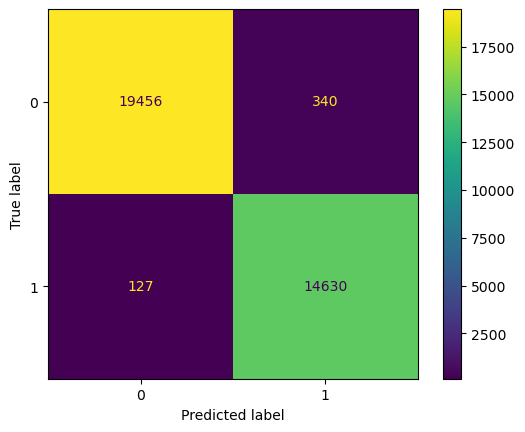

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Lets Check the confusion Matrix for the model trained on 50% dataset
y_pred = grid_svc_a.best_estimator_.predict(X_test)

#Genearte confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_svc_a.best_estimator_.classes_)

disp.plot()
plt.show()

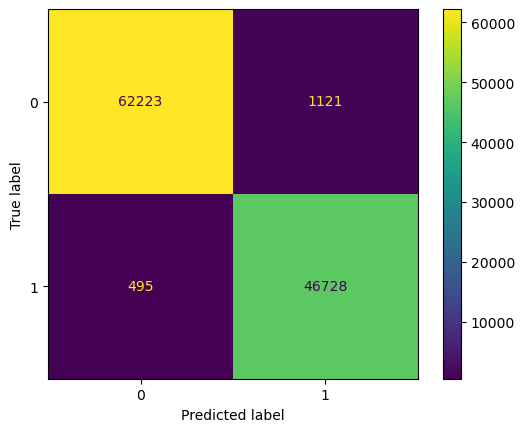

In [57]:
#Lets Check the confusion Matrix for the model tuned on full dataset
y_pred = grid_svc_a.best_estimator_.predict(X_train)

#Genearte confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_svc_a.best_estimator_.classes_)

disp.plot()
plt.show()

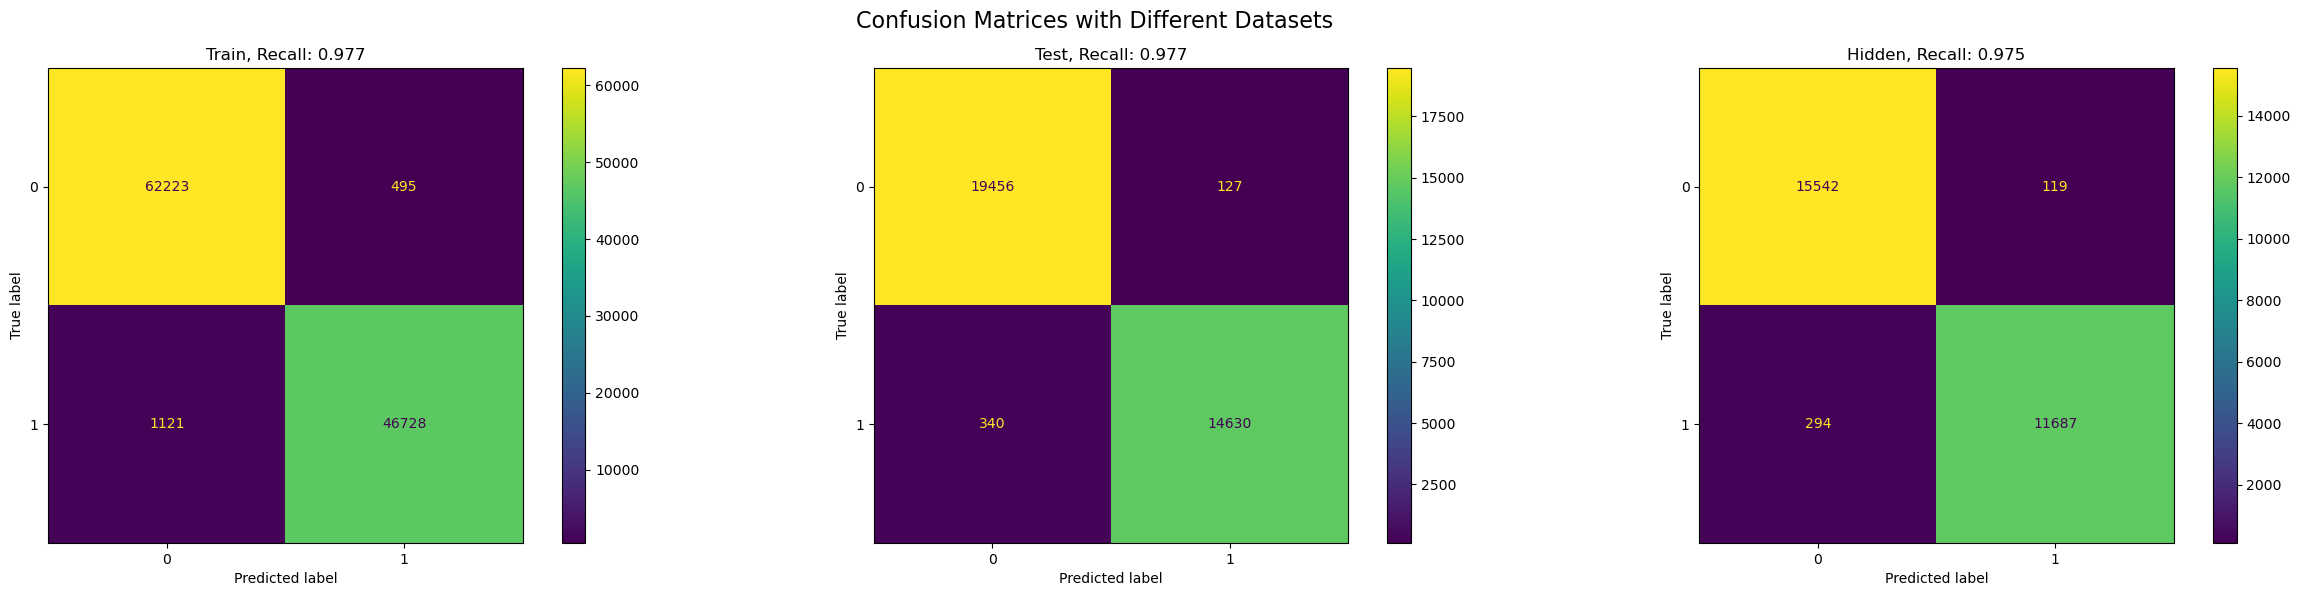

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6)) 
fig.suptitle('Confusion Matrices with Different Datasets', fontsize = 16)

# Loop through each dataset
for i, data in enumerate([[X_train, y_train, 'Train'],[X_test, y_test,'Test'], [X_hidden,y_hidden,'Hidden']]):
    y_pred = grid_svc_a.best_estimator_.predict(data[0])

    recall = recall_score(y_pred, data[1])
    
    # Generate the confusion matrix
    cm_adjusted = confusion_matrix(y_pred, data[1])
    disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted, display_labels=grid_svc_a.best_estimator_.classes_)
    disp_cm.plot(ax=axes[i])

    # Set the title with precision score
    axes[i].set_title(f'{data[2]}, Recall: {recall:.3f}')

plt.savefig(r'C:\data\capstone\analysis\cm_comparison_svc.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

Here, it is clear that if the model predicts that OTD will not be met, then, corrective action is definitely needed. The recall for this model is excellent along with precisio and AUC-ROC

In [58]:
#In the currently identified best model, let us find the permutation importance
pim = permutation_importance(grid_svc_a.best_estimator_, X_hidden, y_hidden, n_repeats=10, n_jobs = -1, random_state=42, scoring='recall') #Using hidden dataset here to udnerstand impact on unseen data
for i, feature in enumerate(X_hidden.columns):
    print(f'{feature}: {pim.importances_mean[i]}')

Type: -0.00040657292901915556
Days for shipment (scheduled): 0.3261731323056073
Benefit per order: 0.0007962053193291796
Customer City: 0.0038285617482636037
Customer Country: 0.0007538539725563508
Customer Id: 0.0005420972386922073
Customer Segment: -0.0004828053532102472
Customer State: 0.0016262917160766222
Department Id: -9.317296290022315e-05
Latitude: 0.007284431644926315
Longitude: 0.002812129425715715
Market: -0.00032187023547349816
Order City: -0.000423513467728287
Order Country: -0.00038963239031002405
Order Item Discount Rate: 9.317296290022315e-05
Order Item Quantity: 0.00013552430967305184
Sales: -2.5410808063697222e-05
Order Region: -0.0005166864306285102
Order State: -0.0009910215144841583
Order Status: -0.0005420972386922073
Shipping Mode: 0.05567508046755888
shipping_dayofweek: 0.3165678468575301
shipping_dayofmonth: 0.23421141792308992
order_dayofweek: 0.3153820091478909
order_month: 0.00032187023547349816
order_year: 0.0008639674741657055
order_dayofmonth: 0.23410977

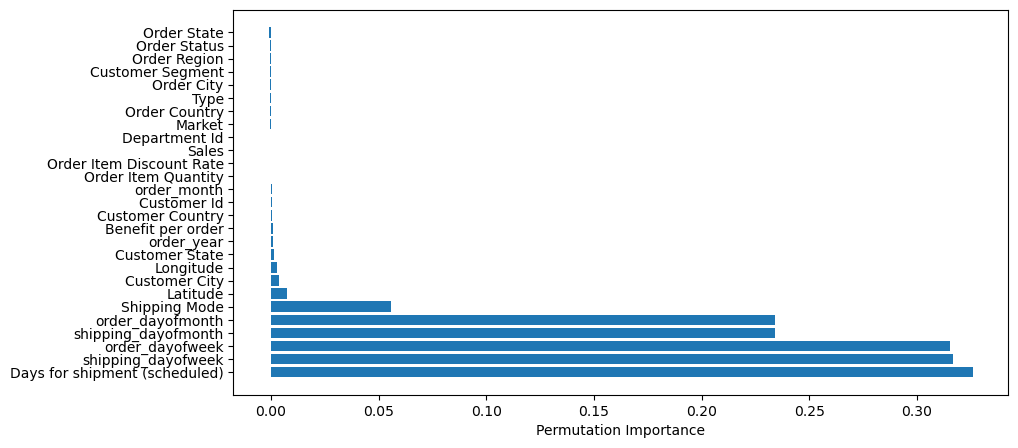

In [61]:
sorted_idx = pim.importances_mean.argsort()[::-1]  # Get indices that would sort the array
importance_sorted = pim.importances_mean[sorted_idx]
features_sorted = X_hidden.columns[sorted_idx]

plt.figure(figsize=(10, 5))
plt.barh(features_sorted, importance_sorted)
plt.xlabel("Permutation Importance")
plt.savefig(r'C:\data\capstone\analysis\PIM_SVM.png', dpi=300, bbox_inches='tight')
plt.show()

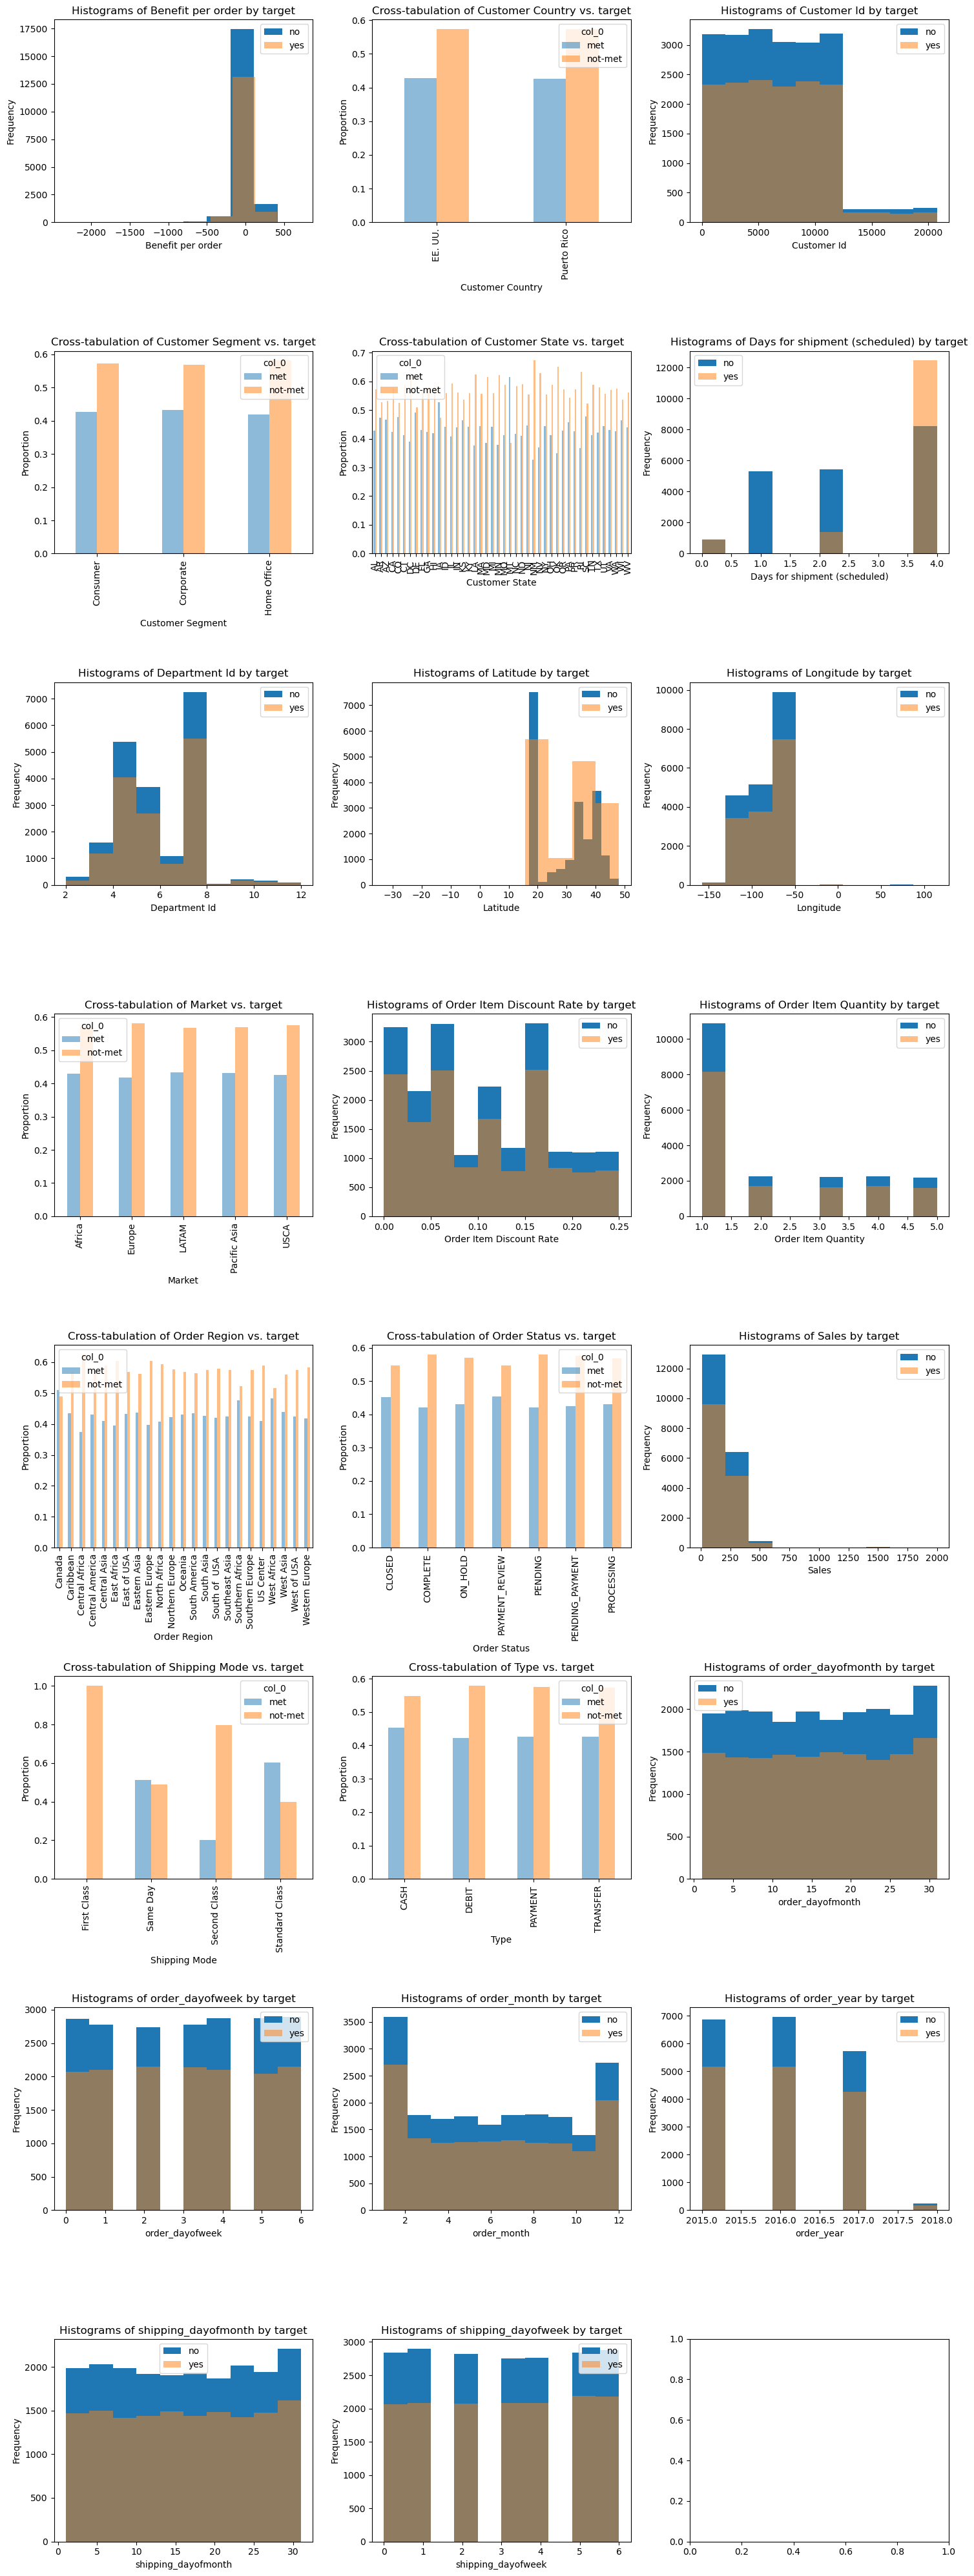

In [113]:
#Lets look at data spread
# Separate categorical and numerical features
categorical_features = X_test.select_dtypes(include=['object', 'category']).columns
categorical_features = categorical_features.difference(['Customer City', 'Order Country', 'Order City', 'Order State'])
numerical_features = X_test.select_dtypes(include=['number']).columns

# Calculate the number of rows needed for the subplots
num_rows = (len(features_sorted.difference(['Customer City', 'Order Country', 'Order City', 'Order State'])) + 2) // 3

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5 * num_rows))
axes = axes.flatten()
y_strings = np.where(y_test == 1, 'met', 'not-met')
# Loop through features and create plots
for i, feature in enumerate(features_sorted.difference(['Customer City', 'Order Country', 'Order City', 'Order State'])):
    if feature in categorical_features:
        # Categorical feature: Create cross-tabulation plot
        cross_tab = pd.crosstab(X_test[feature], y_strings, normalize='index')
        cross_tab.plot(kind='bar', stacked=False, alpha = 0.5, ax=axes[i])
        axes[i].set_title(f"Cross-tabulation of {feature} vs. target")
        axes[i].set_ylabel("Proportion")

    elif feature in numerical_features:
        # Numerical feature: Create cross-histograms with buckets
        axes[i].hist(X_test[y_test == 0][feature], alpha=1, label='no')
        axes[i].hist(X_test[y_test == 1][feature], alpha=0.5, label='yes')
        axes[i].set_title(f"Histograms of {feature} by target")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Frequency")
        axes[i].legend()

# Remove any unused subplots
for i in range(len(features_sorted), len(axes)):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.savefig(r'C:\data\capstone\analysis\Test_data_spread.png', dpi=300, bbox_inches='tight')
plt.show()

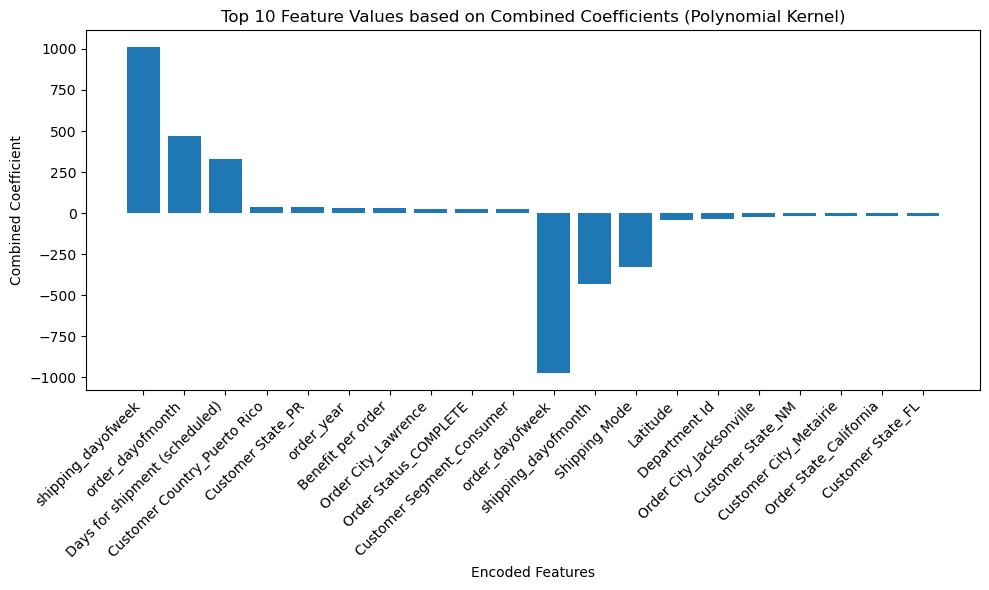

In [112]:
# Get the trained SVC model from the pipeline
pipe = grid_svc_a.best_estimator_

# Get the OneHotEncoder from the pipeline
encoder = pipe.named_steps['transform']
model_svm = pipe.named_steps['classifier']

# # Get feature names after one-hot encoding
feature_names = encoder.get_feature_names_out()

# # Get SVM coefficients
dual_coefficients = model_svm.dual_coef_ 
support_vectors = model_svm.support_vectors_ 
coefficients = np.dot(dual_coefficients, support_vectors) 
coefficients_dense = coefficients.toarray().ravel() 

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients_dense})
coef_df['Feature'] = coef_df['Feature'].apply(lambda x: x.split('_',1)[1][1:]) 


# Get top 10 positive coefficients
top_positive = coef_df.nlargest(10, 'Coefficient')

# Get top 10 negative coefficients
top_negative = coef_df.nsmallest(10, 'Coefficient')

# Combine the top positive and negative coefficients
top_coefficients = pd.concat([top_positive, top_negative])

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_coefficients['Feature'], top_coefficients['Coefficient'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Encoded Features')
plt.ylabel('Combined Coefficient')
plt.title('Top 10 Feature Values based on Combined Coefficients (Polynomial Kernel)')
plt.tight_layout()

plt.savefig(r'C:\data\capstone\analysis\individual_feature_values.png', dpi=300, bbox_inches='tight')

plt.show()

### Next Steps

#### Ensemble model

#### Final Productionalization